In [2]:
import gtfs_kit as gk
import h3
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd
import os

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [12]:
def get_stops_from_gtfs(path):
    feed = (gk.read_feed(path, dist_units='km'))
    return feed.get_stops()

In [32]:
def stops2hex(stops, resolution, hex_col):

    # find hexs containing the points
    stops[hex_col] = stops.apply(lambda x: h3.geo_to_h3(x.stop_lat,x.stop_lon,resolution),1)

    # aggregate the points
    stopsg = stops.groupby(hex_col).size().to_frame('cnt').reset_index()

    #find center of hex for visualization
    stopsg['stop_lat'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    stopsg['stop_lon'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    
    return stopsg

In [31]:
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['stop_lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['stop_lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

In [59]:
# put all gtfs zips in one directory

# assign directory
directory = '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips'

# iterate over files in
# that directory
files = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        files.append(f)

In [60]:
# Load all data and append to a single df
stops = pd.DataFrame()
for f in files:
    if stops.empty:
        stops = get_stops_from_gtfs(f) 
    else:
        temp_stops = get_stops_from_gtfs(f)
        stops = stops.append(temp_stops)

In [61]:
# convert all data to hex
resolution = 9
hex_col = 'hex'+str(resolution)
stops_hex = stops2hex(stops, resolution, hex_col)

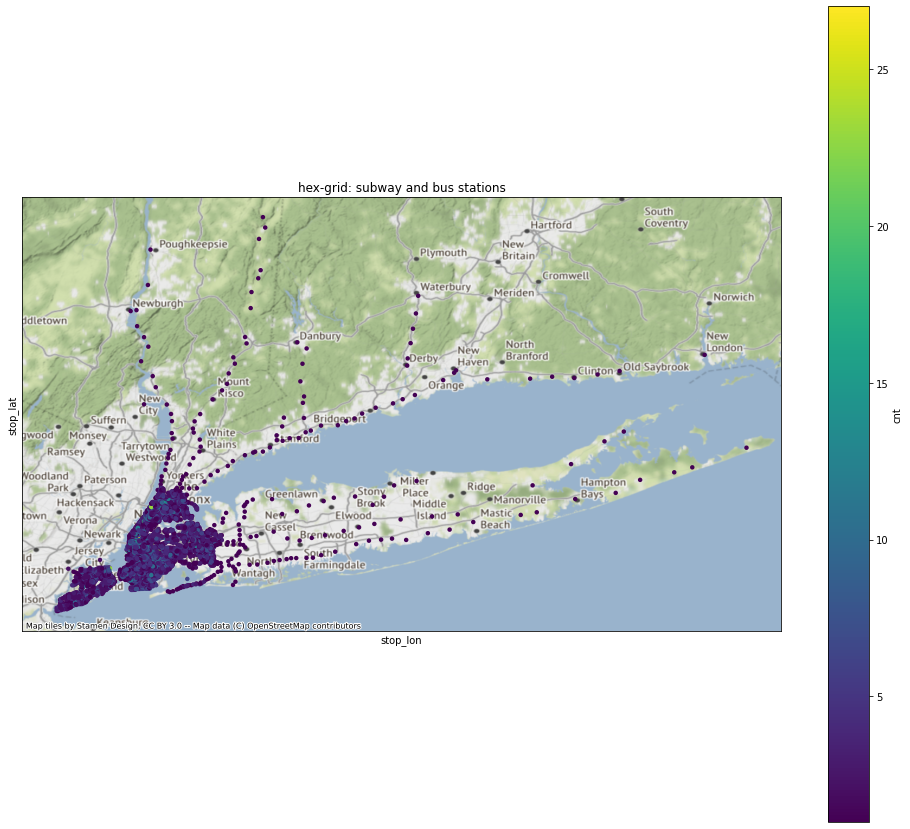

In [62]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# plot the hexs
stops_hex.plot.scatter(ax=ax, x='stop_lon', y='stop_lat', c='cnt',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])

plt.title('hex-grid: subway and bus stations');

cx.add_basemap(ax=ax, crs="EPSG:4326")

sum sanity check: 1.0


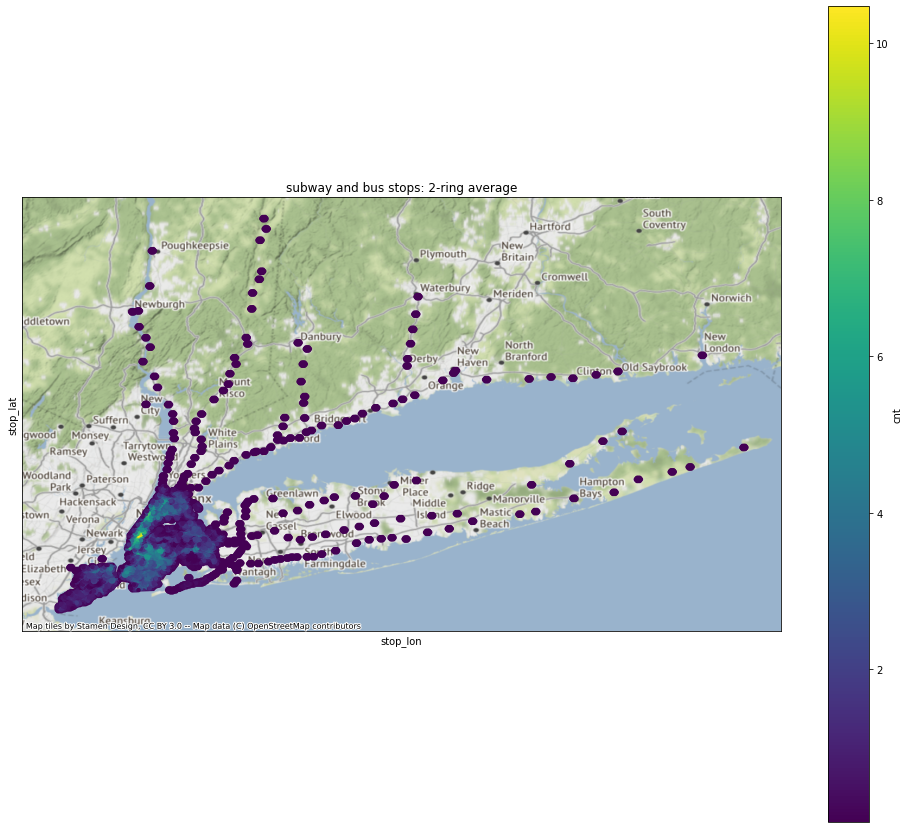

In [63]:
#kring_smoothing
k = 2
stops_kring= kring_smoothing(stops_hex, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', stops_kring['cnt'].sum() / stops_hex['cnt'].sum())

fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stops_kring.plot.scatter(ax=ax, x='stop_lon', y='stop_lat', c='cnt',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway and bus stops: 2-ring average');

cx.add_basemap(ax=ax, crs="EPSG:4326")